In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import cmasher as cmr
cmap = cmr.dusk

from tqdm import tqdm
import joblib 

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

import sys
sys.path.append("/home/jdli/transpec")

import time
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from kvxp.xpformer import XPAPformer, XPAPformerConv,XPAPformerConv2 CNN
from kvxp.data import XPAP4l
# from kvxp.xpformer import XPformer, XPformer2, CNN
# from kvxp.data import  GXP_AP_4lb, GXP_5lb, GXP_4lb
from kvxp.utils import *
from kvxp.vis import draw_hist2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda:1')


k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

gdf = pd.read_csv("/data/jdli/gaia/ap17_332904.csv")


/tmp/ipykernel_17778/490694522.py:7: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv("/data/jdli/gaia/ap17_332904.csv")


In [16]:
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']
true_err_names = ['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']

gdf = gdf[true_names+true_err_names+["GAIAEDR3_SOURCE_ID", "GAIA"]]

In [3]:
data_dir = "/data/jdli/gaia/"
tr_file = "apspec_xp_173344.dump"

gdata  = XPAP4l(data_dir+tr_file, device=device, part_train=False)

In [80]:
def recover_scale_label(y_hat, scaler_name='../models/scaler_labels_0228.gz'):
    scaler_labels = joblib.load(scaler_name)
    y   = scaler_labels.inverse_transform(y_hat)
    # e_y = e_y_hat * scaler_labels.scale_
    return y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     model_type='xpformer', use_ap=False,
                     device=torch.device('cuda:0')):
    
    out_lst = np.array([])
    y_lst = np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            if model_type == "xpformer":
                
                if use_ap:
                    ap = data['ap']
                else:
                    ap = None
                    
                output = model(xp=data['xp'], ap=ap, xp_mask=data['xp_mask'])
                
            elif model_type == "cnn":
                
                output = model(data['xp'])
                
            out_lst  = np.append(out_lst,  output[:,:4].cpu().numpy())
            y_lst    = np.append(y_lst, data['y'].cpu().numpy()) 
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y_lst = np.array(y_lst).reshape(-1,4)
    y_pred = transcale_method(out_lst)
    y_true = transcale_method(y_lst)
    return {'labels_true':y_true, 'labels_pred':y_pred, 'source_id':id_lst}


In [125]:
!ls /data/jdli/gaia/model/0310_attnconv/

sp2_4l_0_ep0.pt		     xp2_4l_freezattn_0_ep150.pt
sp2_4l_0_ep50.pt	     xp2_4l_freezattn_0_ep200.pt
xp2_4l_freezattn_0_ep0.pt    xp2_4l_freezattn_0_ep50.pt
xp2_4l_freezattn_0_ep100.pt


In [132]:
fold = 0
epoch = 50
# model_dir  = "/data/jdli/gaia/model/0310_attnconv/"
model_dir  =  "/data/jdli/gaia/model/0310_attnconv/"
save_point = f"sp2_4l_{fold}_ep{epoch}.pt"


n_dim = 64
n_xp  = 110
n_ap  = 128
n_outputs = 4
n_head =  8
n_layer = 8

model = XPAPformerConv(n_xp, n_ap, n_outputs, device=device, channels=n_dim).to(device)
model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))


<All keys matched successfully>

In [128]:
pred_names   = ['teff_ap', 'logg_ap',  'moh_ap', 'aom_ap']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

BATCH_SIZE = int(2**10)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        labels_infer = infer_4lbs_model(
            model, val_loader, 
            device=device, model_type='xpformer', use_ap=True,
            transcale_method=recover_scale_label,
        )

        rdf = pd.DataFrame(np.c_[labels_infer['labels_true'],
                                 labels_infer['labels_pred'],
                                 labels_infer['source_id']], 
                           columns=true_names+pred_names+['source_id'])
        
print(rdf.shape)
# rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", how='left')


FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.56it/s]

(34669, 9)


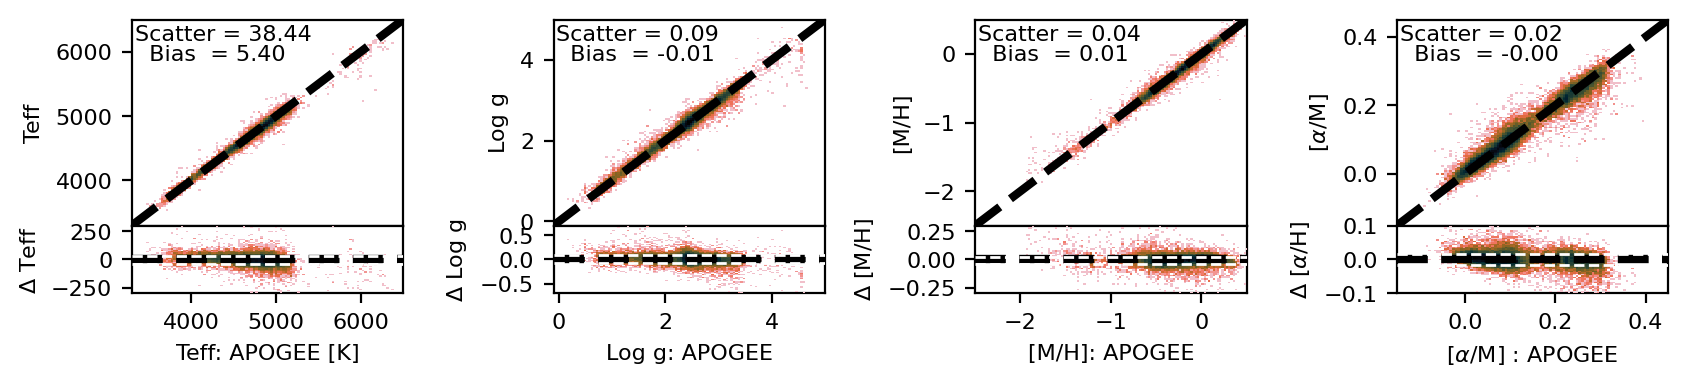

In [130]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))


xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.3, 0.3], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = pred_names

    ax1, ax2 = draw_hist2d(
        axs[i], rdf[true_names[i]], rdf[ynames[i]],
        xrange=xranges[i], bins=100,
        cmap='cmr.dusk_r'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

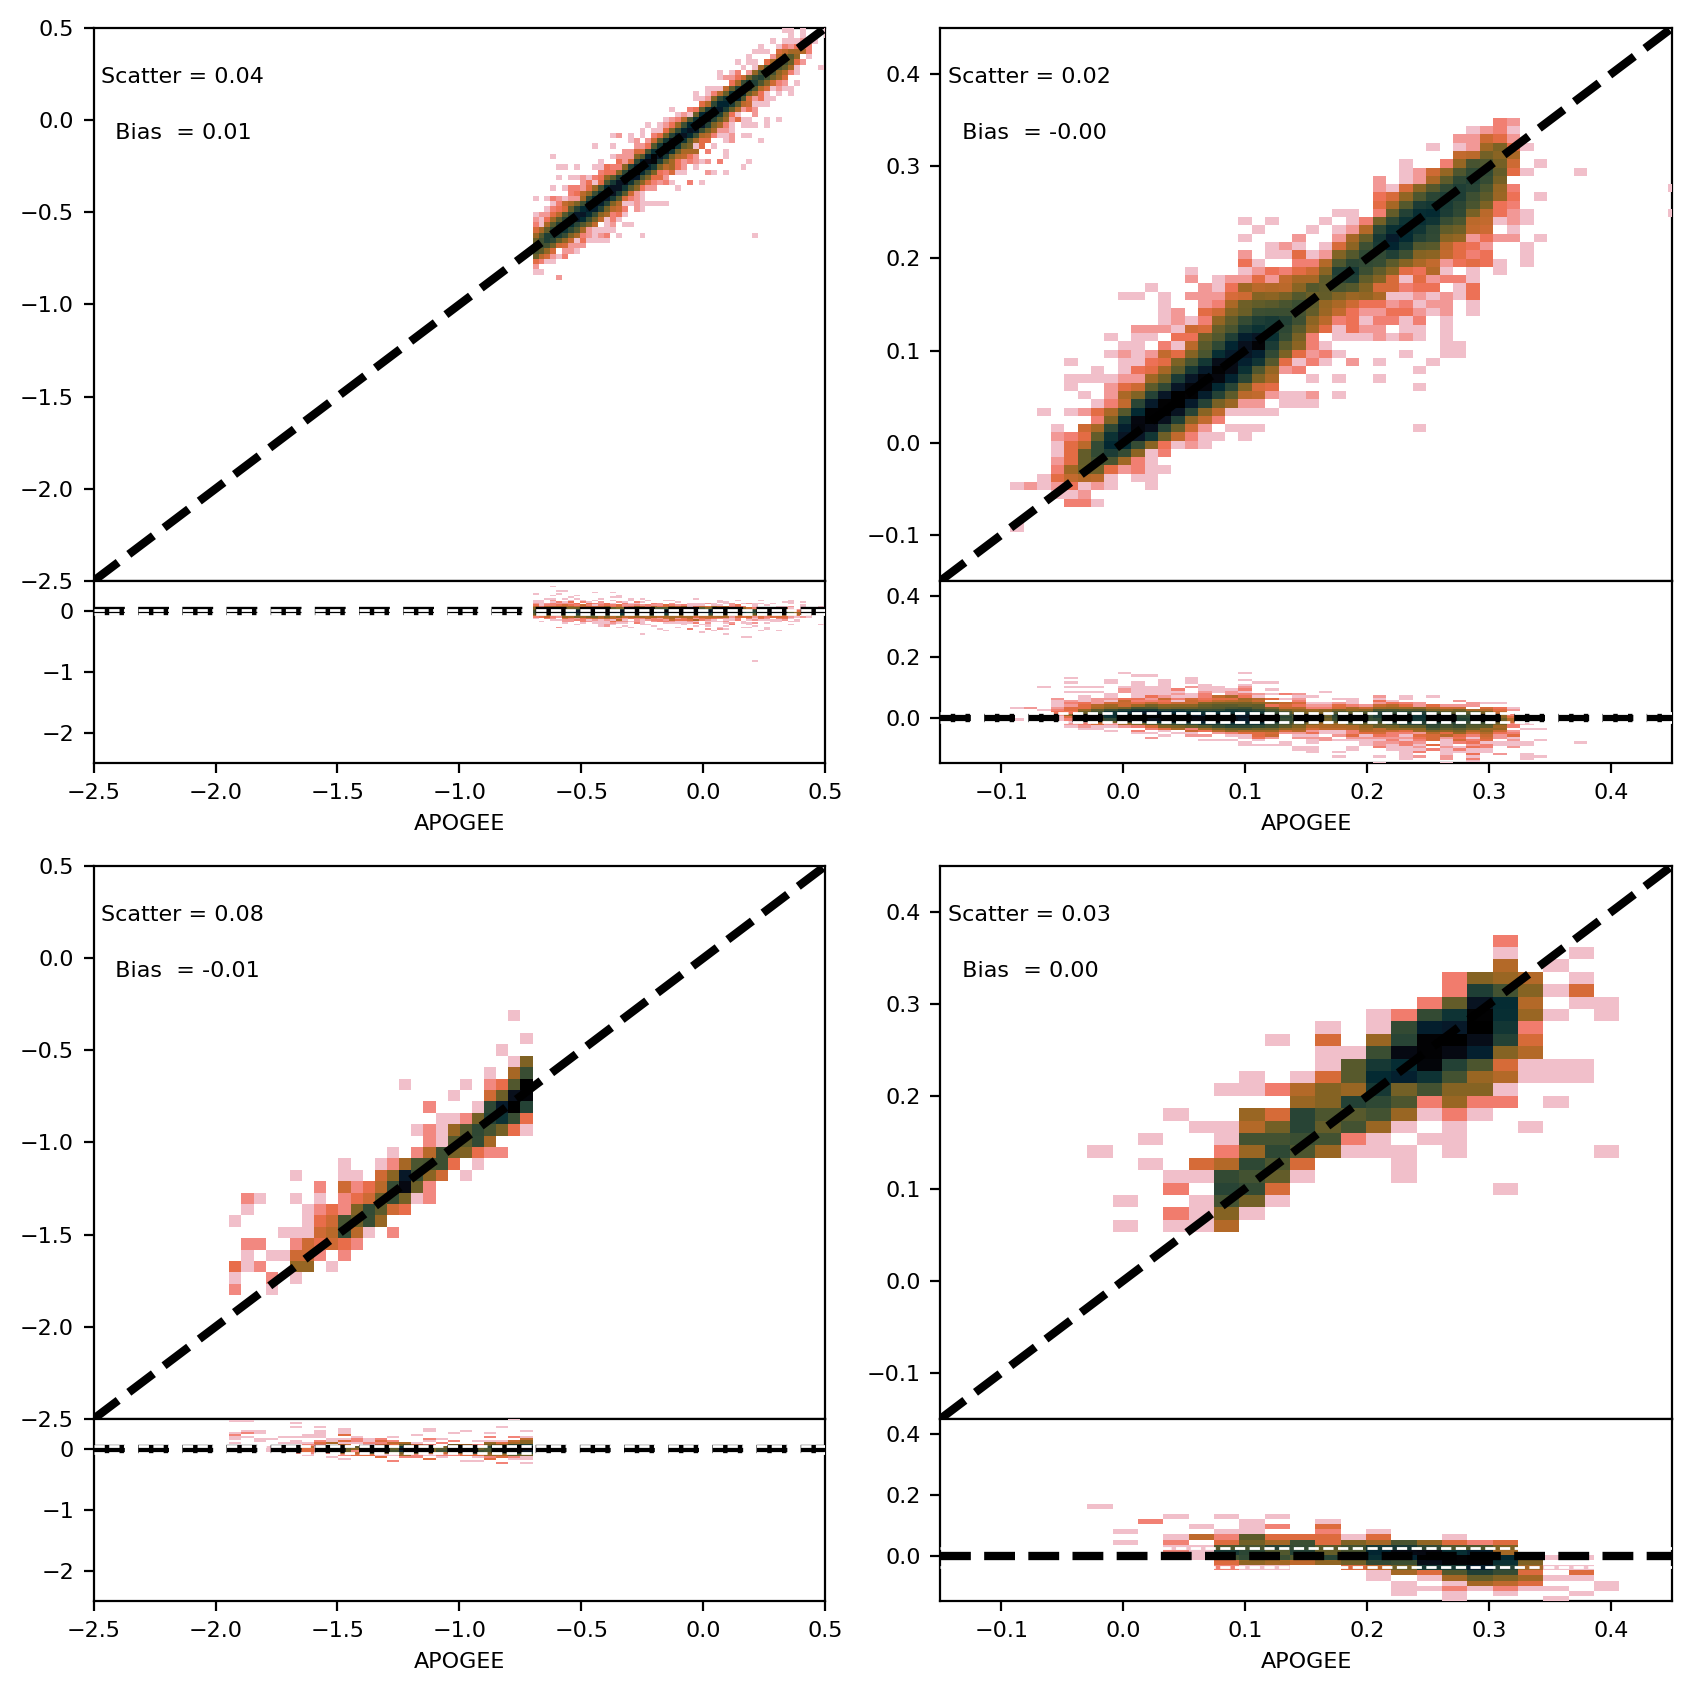

In [105]:
mask_lst = [rdf['M_H']>-0.7,  rdf['M_H']<-0.7]
bin_sizes = [50, 25]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']
pred_names = ['moh_ap', 'aom_ap']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf[mask_lst[j]]
        ax1, ax2 = draw_hist2d(
            axs[j,i], rdf[true_names[i]][mask_lst[j]], 
            rdf[pred_names[i]][mask_lst[j]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk_r'
        )
        
plt.tight_layout()

In [ ]:
fold = 0
epoch = 500

model_dir  =  "/data/jdli/gaia/model/0310_attnconv2/"
save_point = f"xp2_4l_{fold}_ep{epoch}.pt"

n_dim = 64
n_xp  = 110
n_ap  = 128
n_outputs = 4
n_head =  8
n_layer = 8

model = XPAPformerConv2(n_xp, n_ap, n_outputs, device=device, channels=n_dim).to(device)
model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))

pred_names   = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

BATCH_SIZE = int(2**10)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        labels_infer = infer_4lbs_model(
            model, val_loader, 
            device=device, model_type='xpformer', use_ap=False,
            transcale_method=recover_scale_label,
        )

        rdf_xp = pd.DataFrame(
            np.c_[labels_infer['labels_true'], labels_infer['labels_pred'], labels_infer['source_id']], 
                              columns=true_names+pred_names+['source_id'])
        
print(rdf_xp.shape)



In [113]:
true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

rdf_xp = pd.DataFrame(
            np.c_[labels_infer['labels_true'], labels_infer['labels_pred'], labels_infer['source_id']], 
                              columns=true_names+pred_names+['source_id'])

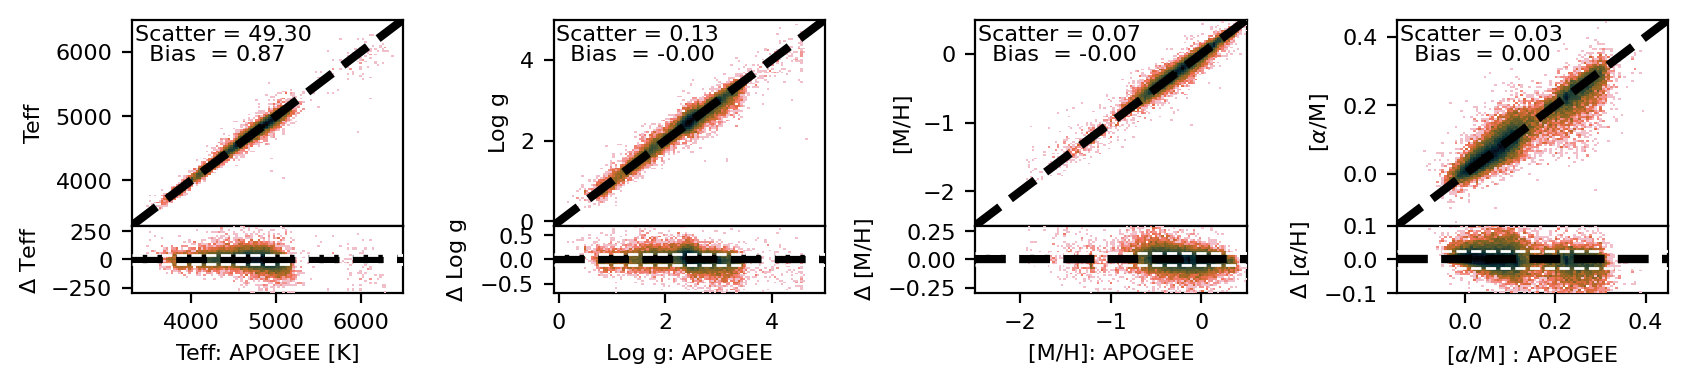

In [114]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))


xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.3, 0.3], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_xp', 'logg_xp',  'moh_xp', 'aom_xp']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_xp[true_names[i]], rdf_xp[ynames[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()

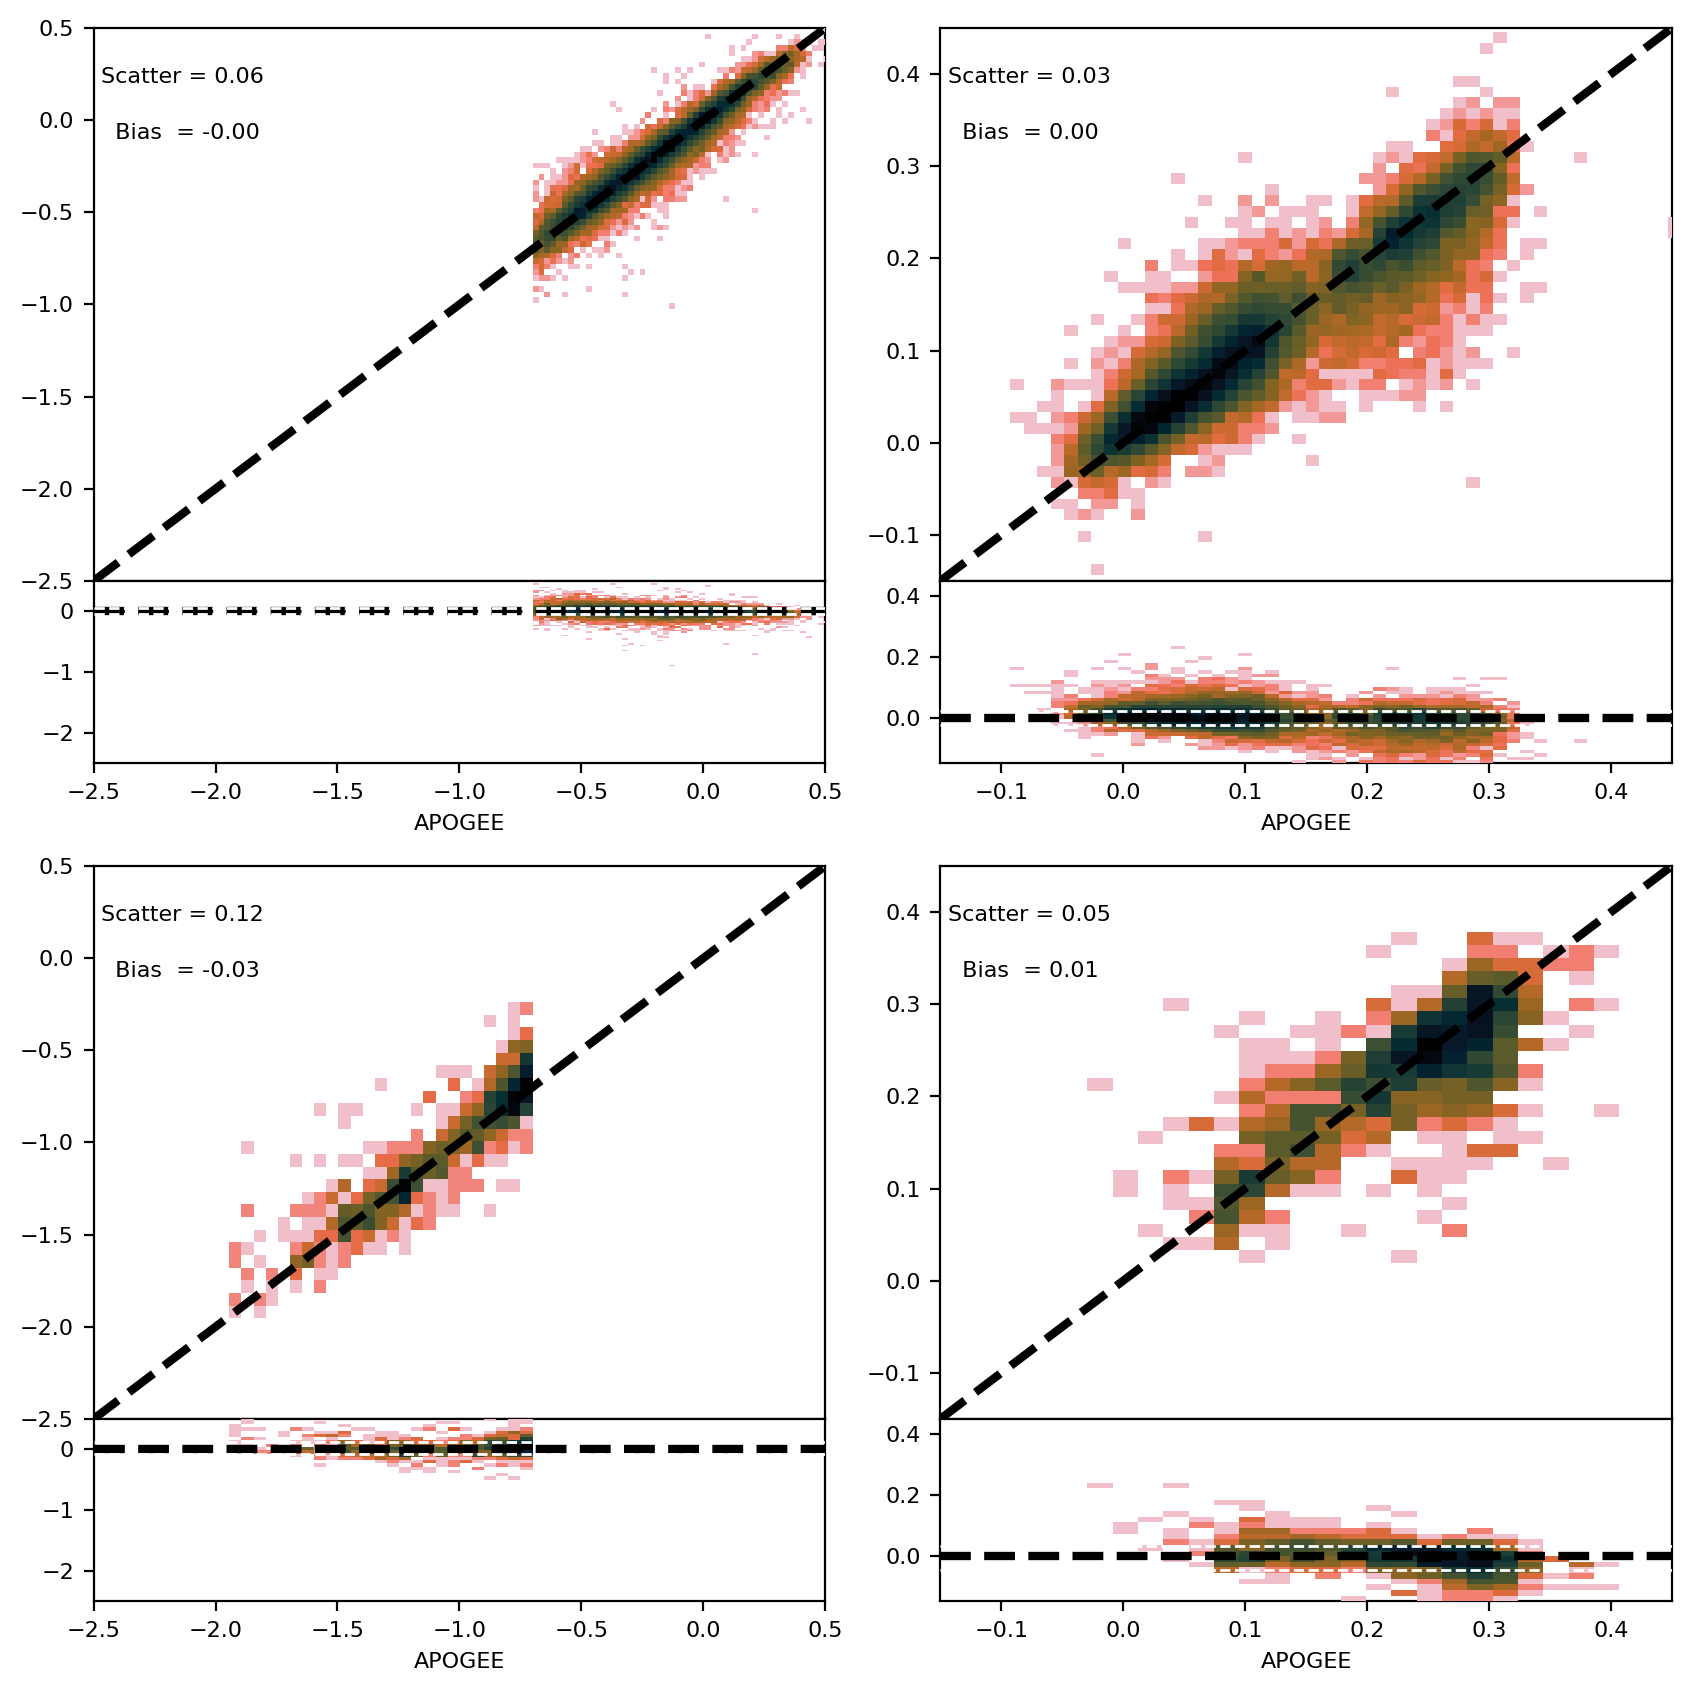

In [115]:
mask_lst = [rdf_xp['M_H']>-0.7,  rdf_xp['M_H']<-0.7]
bin_sizes = [50, 25]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']
pred_names = ['moh_xp', 'aom_xp']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_xp[mask_lst[j]]
        ax1, ax2 = draw_hist2d(
            axs[j,i], rdf_xp[true_names[i]][mask_lst[j]], rdf_xp[pred_names[i]][mask_lst[j]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk_r'
        )
        
plt.tight_layout()

In [117]:
rdf_xp.source_id = rdf_xp.source_id.astype(int)
rdf_xp.head()

,TEFF,LOGG,M_H,ALPHA_M,teff_xp,logg_xp,moh_xp,aom_xp,source_id
0,4847.523002,2.396415,-0.388300,0.240925,4840.293650,2.380209,-0.404173,0.227089,1463982037118519552
1,4600.912598,2.402640,0.053661,0.070030,4559.624161,2.331628,0.077322,0.068719,1633561609553449984
2,4638.194999,2.441383,-0.078904,0.146275,4646.259477,2.461686,-0.085609,0.142718,921400781416459008
3,4768.619600,2.515863,0.052710,0.009289,4806.828409,2.563855,0.085907,-0.012156,839265201237783296
4,4985.995995,2.412627,-0.526150,0.240805,4947.345666,2.358236,-0.600759,0.229794,1315749521593993728


In [119]:
rdf_xp = rdf_xp.merge(gdf, left_on='source_id', right_on="GAIAEDR3_SOURCE_ID")
rdf_xp.shape

(113256, 18)

In [ ]:
mask_lst = [rdf_xp['GAIAEDR3_SOURCE_ID']>15,  rdf_xp['GAIAEDR3_SOURCE_ID']<15]
bin_sizes = [50, 25]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H_x', 'ALPHA_M_x']
pred_names = ['moh_xp', 'aom_xp']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_xp[mask_lst[j]]
        ax1, ax2 = draw_hist2d(
            axs[j,i], rdf_xp[true_names[i]][mask_lst[j]], rdf_xp[pred_names[i]][mask_lst[j]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk_r'
        )
        
plt.tight_layout()

# CNN baseline

In [85]:
fold = 0
epoch = 250
model_dir = "/data/jdli/gaia/model/0303_cnn/"
save_point = f"sp2_4l_{fold}_ep{epoch}.pt"


n_enc = 11
n_outputs = 4
n_dim = 8
n_xp = 110

model = CNN(
    n_xp, n_outputs, 
).to(device)

model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))


pred_names   = ['teff_cnn', 'logg_cnn',  'moh_cnn', 'aom_cnn']
BATCH_SIZE = int(2**10)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        labels_infer = infer_4lbs_model(
            model, val_loader, 
            device=device, 
            model_type='cnn',
            transcale_method=recover_scale_label,
        )

        rdf_cnn = pd.DataFrame(np.c_[labels_infer['labels_true'],
                                 labels_infer['labels_pred'],
                                 labels_infer['source_id']], 
                           columns=true_names+pred_names+['source_id'])
# print(rdf.shape)
# rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
#                      suffixes=(None, '_y'))
# rdf_val.shape


FOLD 0
--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.60it/s]


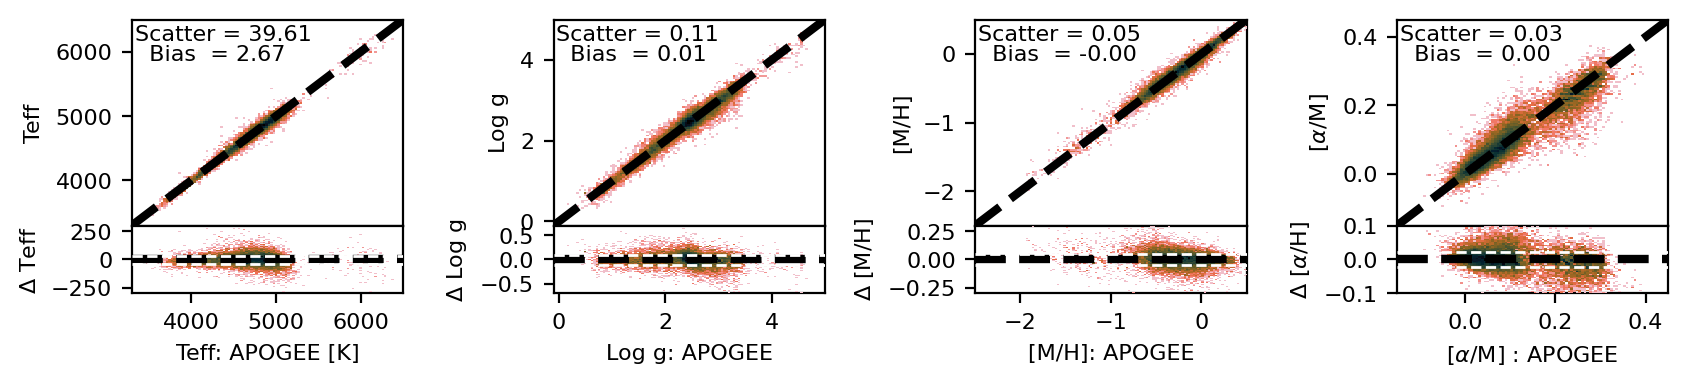

In [86]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))


xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-300, 300],  [-0.7, 0.7],   [-0.3, 0.3], [-0.1, 0.1]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]
    
for i in range(4):
    ynames = ['teff_cnn', 'logg_cnn',  'moh_cnn', 'aom_cnn']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_cnn[true_names[i]], rdf_cnn[ynames[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

plt.tight_layout()